In [1]:
%matplotlib inline
import matplotlib     

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['text.usetex'] = False
import scipy.interpolate as itp
import scipy.signal as sig
import scipy.stats as stats
from netCDF4 import Dataset
#from SW_Density import SW_Density
from comp_rho import rhop
from distance_sphere_matproof import dist_sphere_matproof
from convert_TPXO_to_ellipses import ellipse
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from change_coord import reproject_image_into_polar
#from mpi4py import MPI 
from pad_coords import pad_coords   # for padding fields outside of domain
clock  = datetime.now()

import time

doverb = True

lek, lef = {}, {}

In [2]:
# --- MPI parameters --- 
#npx,npy = 8,16 # number of processors in x and y directions  
npx,npy = 1,1 # number of processors in x and y directions  
#comm = MPI.COMM_WORLD
#rank = comm.Get_rank()
#size = comm.Get_size()
rank, size = 0, 1
if size!=npx*npy:
    exit('number of subdomains different from number of procs -> failure!')

# --- data location ---
path_data = '/data0/project/vortex/lahaye/Tide_Conv/input_data/' #'./input_data/' #
path_data = '/net/krypton'+path_data     # if not on LOPS hub

# --- climato ---
clim = "lucky"
if clim == "lucky":
    cname = path_data+"lucky_ts_meanSODA_winter.nc"

# --- topography dataset --- 
topo = "lucky"

# --- tide dataset --- 
collot = True    # tides and topo defined on same points // False not implemented
tide = 'lucky'
uname     = path_data+'luckym2_frc.nc' # see read_write_TPXO8_netcdf.py

# --- global grid ---   
colloc = True    # use same grid as topo // False not implemented
if colloc:
    nstep = 10
else:
    dspace            = 1e3       # resolution of the final map in meter
lonmin_g,lonmax_g = -33,-32     # test box // None takes the whole domain defined by h  
latmin_g,latmax_g = 37,37.7  
#lonmin_g, latmin_g, lonmax_g, latmax_g = [None]*4  # entire domain

# --- output location and name --- 
path_write = path_data.replace('input','output')
file_write = 'Ef_'+topo+'_mpi%.3i.nc'%rank  # lonmin,lonmax,latmin,latmax 
#file_write = 'test_npts400_%.2i.nc'%rank  # lonmin,lonmax,latmin,latmax 

# --- miscellaneous --- 
if topo == "lucky":
    file_topo = path_data+"lucky_grd.nc"
    Lchk = 150e3    # length of window for computing topo spectrum
    varx, vary = 'lon_rho', 'lat_rho'
    varh = 'h'

zmin       = -100              # min depth to compute Ef [m], below contin. shelf roughly
g          = 9.81              # gravity [m s-2]
omega      = 7.2921e-5         # Earth's rotation rate [rad s-1]
M2         = 2.*np.pi/(44700.) # M2 tide frequency [rad s-1] 
lonm,latm  = -32.16,37.17      # Momar mooring location 
Erad = 6371e3                  # Earth radius [m]

### warning: make sure the foillowing lines are in agreement with subsequent parameters and grids
nxout = 256
nxoth = 128
khout = np.linspace(1./Lchk,1./750/np.sqrt(2.),nxout)*np.pi  # k adim for output = k*bar(N)*H/sqrt(M2^2-f^2)
thout = np.linspace(0,np.pi*2,nxoth+1)[:-1]  # theta for output

In [3]:
# ------ get mean topo on the grid, will be used to get N2b --------
# load the entire grid (regional modelling purpose)
nc   = Dataset(file_topo,'r') # etopo2 and srtm30 files have the same structure
if topo == 'lucky':
    lon_h = nc.variables[varx][:].T
    lat_h = nc.variables[vary][:].T
    if lonmin_g is None:
        ix = [0]
    else:
        ix = [np.abs(lon_h-lonmin_g).argmin(axis=0).min()]
    if lonmax_g is None:
        ix.append(lon.shape[0])
    else:
        ix.append(np.abs(lon_h-lonmax_g).argmin(axis=0).max())
    if latmin_g is None:
        jy = [0]
    else:
        jy = [np.abs(lat_h-latmin_g).argmin(axis=1).min()]
    if latmax_g is None:
        jy.append(lat.shape[1])
    else:
        jy.append(np.abs(lat_h-latmax_g).argmin(axis=1).max())
    #h = -nc.variables[varh][jy[0]:jy[1],ix[0]:ix[1]].T
    #hgrid[hgrid>=-2.5]     = 0     # land points  
    #lon = lon[ix[0]:ix[1],jy[0]:jy[1]]
    #lat = lat[ix[0]:ix[1],jy[0]:jy[1]]
    #Nxh, Nyh = lon_g.shape
    nlon_h, nlat_h = lon_h.shape
nc.close()

In [4]:
# --- grids (coordinates relative to proc number) ---
# working with (x,y)-ordered grids
if colloc:
    lon2d_g = lon_h[ix[0]:ix[1]:nstep,jy[0]:jy[1]:nstep]
    lat2d_g = lat_h[ix[0]:ix[1]:nstep,jy[0]:jy[1]:nstep]
    nlon_g, nlat_g = lon2d_g.shape
else:
    lon1d_g       = np.arange(lonmin_g,lonmax_g+dspace,dspace) 
    lat1d_g       = np.arange(latmin_g,latmax_g+dspace,dspace) 
    nlat_g,nlon_g = lat1d_g.shape[0],lon1d_g.shape[0] 
di            = nlon_g//npx
dj            = nlat_g//npy
if di*npx<nlon_g: di+=1 # correction to make sure all the area is covered
if dj*npy<nlat_g: dj+=1
imin          = di*(rank%npx)
jmin          = dj*(rank//npx)
imax          = imin+di
jmax          = jmin+dj

# --- define subgrids ---
if colloc:
    lon2d, lat2d = lon2d_g[imin:imax,jmin:jmax], lat2d_g[imin:imax,jmin:jmax]
else:
    lon1d = lon1d_g[imin:imax] 
    lat1d = lat1d_g[jmin:jmax] 
    lon2d,lat2d = np.meshgrid(lon1d,lat1d)  
nlon,nlat = lon2d.shape
lonmin,lonmax = np.nanmin(lon2d),np.nanmax(lon2d)
latmin,latmax = np.nanmin(lat2d),np.nanmax(lat2d)

if size > 1:
    lonall = comm.gather([lonmin,lonmax],root=0)
    latall = comm.gather([latmin,latmax],root=0)
    dimall = comm.gather([nlat,nlon],root=0)
else:
    lonall = [[lonmin,lonmax]]
    latall = [[latmin,latmax]]
    dimall = [[nlat,nlon]]
    
if rank==0:
    print('Total domain : lon in [%.1f,%.1f], lat in [%.1f,%.1f]'%(lonmin_g,lonmax_g,latmin_g,latmax_g))
    for i in range(size):  
        print(' Processor %.3i will do lon in [%.1f,%.1f], lat in [%.1f,%.1f], [%i x %i] points'\
              %(i,lonall[i][0],lonall[i][1],latall[i][0],latall[i][1],dimall[i][1],dimall[i][0]) )
        
if colloc:
    nc = Dataset(file_topo,'r')
    hgrid = -nc.variables[varh][jy[0]:jy[1]:nstep,ix[0]:ix[1]:nstep].T[imin:imax,jmin:jmax]
    hgrid[hgrid>=-2.5] = 0.
    nc.close()
else:
    raise ValueError('colloc False not implementend for hgrid: need to interpolate')
    
# --- Coriolis frequency [rad s-1] ---
f = 2*omega*np.sin(lat2d*np.pi/180.) 


Total domain : lon in [-33.0,-32.0], lat in [37.0,37.7]
 Processor 000 will do lon in [-33.1,-32.0], lat in [37.0,37.9], [13 x 15] points


In [5]:
# ------ extract Tides ------------------------------
nc   = Dataset(uname,'r') # variables are on C-grid 

if not (tide=='lucky' and collot and colloc):
    raise ValueError('choice for tide and collot not implemented')

phi = nc.variables['tide_Cangle'][0,...].T[ix[0]:ix[1]:nstep,jy[0]:jy[1]:nstep][imin:imax,jmin:jmax]
pha = nc.variables['tide_Cphase'][0,...].T[ix[0]:ix[1]:nstep,jy[0]:jy[1]:nstep][imin:imax,jmin:jmax]
ue = nc.variables['tide_Cmax'][0,...].T[ix[0]:ix[1]:nstep,jy[0]:jy[1]:nstep][imin:imax,jmin:jmax]
ve = nc.variables['tide_Cmin'][0,...].T[ix[0]:ix[1]:nstep,jy[0]:jy[1]:nstep][imin:imax,jmin:jmax]

nc.close()

phi = phi*np.pi/180  # [rad] 

In [6]:
# ------ extract density profile, compute N2 ------------------
if clim == "lucky":
    nc = Dataset(cname,'r')
    T = nc.variables['temp_roms_avg'][:]
    S = nc.variables['salt_roms_avg'][:]
    zz = nc.variables['depth'][:]

rho = np.sort(rhop(T,S)) #SW_Density(T,S) # sorting is cheating here
rho0 = rho.mean()
frho = itp.pchip(zz[::-1],rho[::-1],extrapolate=True)
N2_tmp = -(g/rho0)*(2*np.pi)**2*frho.derivative()(zz)    # # has to be in [(rad s-1)^2]
indneg, = np.where(N2_tmp<=0.)
for ii in indneg:
    N2_tmp[ii] = (N2_tmp[ii-1] + N2_tmp[ii+1])/2
fN2 = itp.pchip(zz[::-1],N2_tmp,extrapolate=True)    
nz      = N2_tmp.shape[0]

# fit exponential profile
slope,intercept,r_val,p_val,std_err = stats.linregress(zz,np.log(N2_tmp**0.5))
N0  = np.exp(intercept)/(2*np.pi)
b   = 1./slope

if doverb:
    if indneg.size>0:
        print('had to resort stratif for {} values'.format(indneg.size))
    print('exponential interpolation for stratification: N0={0}, b={1}'.format(N0,b))

had to resort stratif for 2 values
exponential interpolation for stratification: N0=0.00319730190622, b=1499.54454263


In [7]:
# ====== BEGINNING OF REGIONAL LOOP ON LAT,LON ======================
Efout     = np.zeros((nlat,nlon,nxout,nxoth))  # energy flux (y,x,kh,theta) 
Efaut   = np.zeros((nlat,nlon,nxout))     # energy flux azimuthally averaged (y,x,kh) 
N2b    = np.zeros((nlon,nlat))        # N2 at the bottom (y,x) 
Ef_t   = np.zeros((nlat,nlon))        # total energy flux (y,x)
h_sp = np.zeros((nlat,nlon,nxout,nxoth))
#kh     = np.zeros((nlat,nlon,nxout))     # horizontal wavenumber 
# theta  = np.zeros((nlat,nlon,nxout))     # azimuth (anti-clockwise from major axis)

if doverb:
    tmes, tmeb = time.clock(), time.time()

for j in [nlat//2]: #ange(nlat): #
    clock_diff = datetime.now() - clock
    hour,sec = divmod(clock_diff.seconds,3600)
    hour     = hour + clock_diff.days*24
    minu,sec = divmod(sec,60)
    print( ' ---> proc %.3i, time spent : %.2i h %.2i min %.2i sec, computation is at %.1f percent'\
          %(rank,hour,minu,sec,float(j)/nlat*100.)) 
    for i in [nlon//2]: #range(nlon): #
        ix, jy = np.unravel_index( ((lon_h-lon2d[i,j])**2 + (lat_h-lat2d[i,j])**2).argmin() , (nlon_h,nlat_h))
        xpos, ypos = lon2d[i,j], lat2d[i,j]
        degy = Lchk/Erad*180./np.pi
        degx = degy/np.cos(ypos*np.pi/180.)
        # search corners (to be sure we have everything)
        isw = np.unravel_index( ((lon_h-lon2d[i,j]+degx)**2 + (lat_h-lat2d[i,j]+degy)**2).argmin() , (nlon_h,nlat_h))
        inw = np.unravel_index( ((lon_h-lon2d[i,j]+degx)**2 + (lat_h-lat2d[i,j]-degy)**2).argmin() , (nlon_h,nlat_h))
        ine = np.unravel_index( ((lon_h-lon2d[i,j]-degx)**2 + (lat_h-lat2d[i,j]-degy)**2).argmin() , (nlon_h,nlat_h))
        ise = np.unravel_index( ((lon_h-lon2d[i,j]-degx)**2 + (lat_h-lat2d[i,j]+degy)**2).argmin() , (nlon_h,nlat_h))
        indx = slice(min(isw[0],inw[0])-1,max(ise[0],ine[0])+1)
        indy = slice(min(isw[1],ise[1])-1,max(inw[1],ine[1])+1)
        nc = Dataset(file_topo,'r')
        h = -nc.variables[varh][indy,indx].T   # working with depth
        nc.close()
        lon = lon_h[indx,indy]
        lat = lat_h[indx,indy]
        nchx, nchy = h.shape
        
        if doverb:
            print('1:',time.clock()-tmes, time.time()-tmeb)
            tmes, tmeb = time.clock(), time.time()
        # --- first, compute distance between grid points 
        xx = dist_sphere_matproof(lat,lon,lat,xpos)
        yy = dist_sphere_matproof(lat,lon,ypos,lon)
        xx[lon<xpos] = -xx[lon<xpos]
        yy[lat<ypos] = -yy[lat<ypos]
        dx = np.diff(xx,axis=0)
        dy = np.diff(yy,axis=1)

        # --- now sets a regular grid dxi=dyi=cst
        dxi   = min(dx.min(),dy.min())*np.sqrt(2.) # grid spacing for interpolation 
        #dxi = 1000
        dyi   = dxi
        xi    = np.arange(-Lchk,Lchk,dxi)
        yi    = np.arange(-Lchk,Lchk,dyi)
        nx, ny = xi.size, yi.size
        # do we need to pad ?
        npadl = npadr = npadt = npadb = 0
        if xi[0] < xx[0,:].min():
            npadl = int((xx[0,:].min()-xi[0])/dxi) + 1
        if xi[-1] > xx[-1,:].max():
            npadr = int((xi[-1]-xx[-1,:].max())/dxi) + 1
        if yi[0] < yy[:,0].min():
            npadb = int((yy[:,0].min()-yi[0])/dyi) + 1
        if yi[-1] > yy[:,-1].max():
            npadt = int((yi[-1]-yy[:,-1].max())/dyi) + 1
        if max(npadl,npadr,npadt,npadb) > 0:
            h = np.pad(h,((npadl,npadr),(npadb,npadt)),'edge')
            lon, lat = pad_coords(lon,lat,(npadl,npadt,npadr,npadb))
            xx = dist_sphere_matproof(lat,lon,lat,xpos)
            yy = dist_sphere_matproof(lat,lon,ypos,lon)
            xx[lon<xpos] = -xx[lon<xpos]
            yy[lat<ypos] = -yy[lat<ypos]
        if doverb:
            print('2:',time.clock()-tmes, time.time()-tmeb)
            tmes, tmeb = time.clock(), time.time()    
        # interpolate topo on uniform grid
        xi,yi = np.meshgrid(xi,yi)
        hi    = itp.griddata((np.ravel(xx),np.ravel(yy)),np.ravel(h),(xi,yi),method='cubic')
        if doverb:
            print('3:',time.clock()-tmes, time.time()-tmeb)
            tmes, tmeb = time.clock(), time.time()
        # --- compute 2D spectrum 
        kx = np.fft.fftshift(np.fft.fftfreq(nx,dxi))*2*np.pi # wavenumbers in x-direction = major axis
        ky = np.fft.fftshift(np.fft.fftfreq(nx,dyi))*2*np.pi # wavenumbers in y-direction = minor axis
        dk = kx[1]-kx[0]
        if doverb:
            print('4:',time.clock()-tmes, time.time()-tmeb)
            tmes, tmeb = time.clock(), time.time()
        win_x   = np.tile(np.hanning(nx),(1,1))  # window before filtering 
        win_y   = np.tile(np.hanning(nx),(1,1)).T
        win     = np.dot(win_y,win_x)
        int_rec = nx**2             # integral of a squared rectangular window (as if no windowing) 
        int_win = np.nansum(win**2) # integral of the squared window 
        norm    = (int_rec/int_win)*1/(nx**2*dk**2) # [1/(rad m-1)^2] normalization constant 
        hr_win = (hi - np.nanmean(hi))*win # remove mean and window the signal 
        sp = norm*abs(np.fft.fftshift(np.fft.fft2(hr_win)))**2
        sp = sp*np.nanvar(hi)/np.sum(sp*dk*dk)
        kx2d,ky2d = np.meshgrid(kx,ky)
        sp[np.where(np.logical_and(kx2d==0.,ky2d==0.))]=np.nan # remove continuous component
        if doverb:
            print('5:',time.clock()-tmes, time.time()-tmeb)
            tmes, tmeb = time.clock(), time.time()
            
        #sp_polar, r, theta = reproject_image_into_polar(sp.T,origin=(nx//2,nx//2),theta_shift=-phi[i,j]*np.pi/180.)
        sp_polar, r, theta = reproject_image_into_polar(sp.T,origin=(nx//2,nx//2))
        kh = r*dk # r is in pixel, multiply by dk to get wavenumber
        sp_polar[sp_polar==0]=np.nan
        #nk = len(kx)//2
        #kh = np.linspace(min(np.abs(kx).min(),np.abs(ky).min()),max(kx.max(),ky.max()),nk)
        #theta = np.linspace(0.,np.pi*2,nk+1)[:-1]
        #sp_polar = itp.RectBivariateSpline(kx,ky,sp,kx=1,ky=1)(kh[:,None]*np.cos(theta)[None,:],kh[:,None]*np.sin(theta)[None,:])
        if doverb:
            print('6:',time.clock()-tmes, time.time()-tmeb)
            tmes, tmeb = time.clock(), time.time()
            
        weight = ( ue[i,j]**2*np.cos(theta)**2 + ve[i,j]**2*np.sin(theta)**2 )
        gamma = np.zeros((nx,nx)) # temp variable 
        #for k in np.arange(nx): 
        #    gamma[k,:] = sp_polar[k,:]*weight
        #for t in np.arange(nx): 
        #    gamma[:,t] = gamma[:,t]*kh
        gamma = sp_polar*weight[None,:]*kh[:,None]
            
        N2b[i,j] = fN2(hgrid[i,j])
        
        # --- compute Ef(K,theta) ---
        coef = 0.5*rho0*((N2b[i,j]-M2**2)*(M2**2-f[i,j]**2))**0.5/M2
        #Ef[j,i,:,:] = coef*gamma                                        # case 1  
        Ef = coef*gamma                                                  # case 2 

        # --- azimuthal integration [0,2pi] ---
        dtheta = theta[1] - theta[0] 
 
        #Ef_a = np.zeros(nx) # temp variable                             # case 1
        #for k in np.arange(nxout): 
            #Ef_a[k] = np.nansum(Ef[j,i,k,:]*kh[j,i,k]*dtheta)/(2*np.pi) # case 1 
            #Ef_a[j,i,k] = np.nansum(Ef[k,:]*kh[j,i,k]*dtheta)/(2*np.pi)  # case 2 
        Ef_a = np.nansum(Ef*dtheta,axis=1)*kh/(2*np.pi)

        # --- equivalent mode number Eq (6) in StL and G 2002 ---  
        #kj = np.arange(nmodes)*np.pi/np.nanmean(-h_1d)*alpha # Eq (4) -> less robust  
        #kj[j,i,:] = np.arange(nmodes)*np.pi*(M2**2-f[j,i]**2)**0.5/(b[j,i]*N0[j,i]) # Eq (6)
        #dkj = kj[j,i,1] - kj[j,i,0] 
        k1 = np.pi*(M2**2-f[i,j]**2)**0.5/(b*N0) # Eq (6)
        dkj = k1 
        # kmin_int : min index over which performing integral
        try:    # ocean points
            kmin_int = np.nanargmin(abs(kh-(k1-0.5*dkj)))+1 
            if doverb:
                print('kmin value {0}, indice {1}'.format(k1,kmin_int))
        except: # land points
            kmin_int = -1
        
        # --- total energy flux ---  
        #Ef_t[j,i] = np.nansum(Ef_a[kmin_int:]*dk)                      # case 1  
        Ef_t[j,i] = np.nansum(Ef_a[kmin_int:]*dk)                   # case 2 
        Efout[j,i,:,:]     = itp.RectBivariateSpline(kh,theta,Ef,kx=1,ky=1)(khout,thout)  # energy flux (y,x,kh,theta) 
        Efaut[j,i,:]   = itp.pchip(kh,Ef_a)(khout)     # energy flux azimuthally averaged (y,x,kh)
        h_sp[j,i,:,:] = itp.RectBivariateSpline(kh,theta,sp_polar,kx=1,ky=1)(khout,thout)  # topo spectrum
# ------ end of loop: print timing ---------------------------
clock_diff = datetime.now() - clock
hour,sec = divmod(clock_diff.seconds,3600)
hour     = hour + clock_diff.days*24
minu,sec = divmod(sec,60)
print(' ===> proc %.3i, time spent : %.2i h %.2i min %.2i sec, save in netcdf file '\
      %(rank,hour,minu,sec)) 

 ---> proc 000, time spent : 00 h 00 min 07 sec, computation is at 46.7 percent
('1:', 0.23533500000000007, 0.29947590827941895)
('2:', 0.03304600000000013, 0.032681941986083984)
('3:', 3.8348359999999997, 2.789401054382324)
('4:', 0.0007880000000000109, 0.0003581047058105469)
('5:', 0.07752399999999948, 0.07250285148620605)
('6:', 0.012293000000000553, 0.012191057205200195)
kmin value 7.14388809476e-05, indice 3
 ===> proc 000, time spent : 00 h 00 min 10 sec, save in netcdf file 


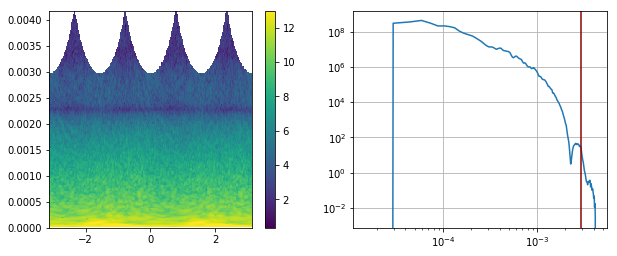

In [8]:
lek[Lchk] = kh
lef[Lchk] = Ef_a

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
hpl = ax1.pcolormesh(theta,kh,np.ma.masked_invalid(np.log10(sp_polar)),vmax=13); 
plt.colorbar(hpl,ax=ax1)
ax2.loglog(kh,np.nansum(sp_polar*dtheta,axis=1)*kh/(2*np.pi))
ax2.grid(True)
ax2.axvline(np.pi/dxi,color='darkred')

1.48089135365e-05
2.21686862267e-05
7.40206447073e-06


7.1438880947644927e-05

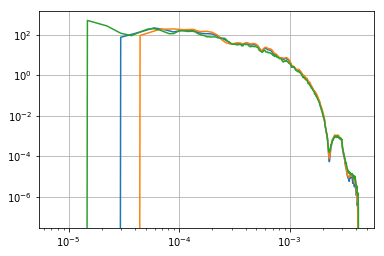

In [36]:
for kk, ff in zip(lek.values(),lef.values()):
    plt.loglog(kk,ff)
    print(kk[1])
plt.grid(True)
ax2.axvline(np.pi/750.,color='darkred')
k1

In [34]:
# ------ save energy flux in netcdf file ---------------------------
nc = Dataset(path_write+file_write,'w')
nc.createDimension('z',zz.size)
nc.createDimension('lon',nlon)
nc.createDimension('lat',nlat)
nc.createDimension('kh',nxout)
nc.createDimension('theta',nxoth)
#nc.createDimension('nmodes',nmodes)
nc.createVariable('z','f',('z',))
nc.createVariable('N2z','f',('z'))
nc.createVariable('lon','f',('lat','lon'))
nc.createVariable('lat','f',('lat','lon'))
nc.createVariable('h','f',('lat','lon'))
nc.createVariable('ue','f',('lat','lon'))
nc.createVariable('ve','f',('lat','lon'))
var = nc.createVariable('phi','f',('lat','lon'))
var.long_name = 'angle between ellipse major-axis and x-axis'
nc.createVariable('N2b','f',('lat','lon'))
nc.createVariable('N0','f',()) # works even if N0 and b are constant 
nc.createVariable('b','f',())
nc.createVariable('f','f',('lat','lon'))
nc.createVariable('kh','f',('kh'))
var.long_name = 'equivalent mode number'
nc.createVariable('theta','f',('theta'))
var = nc.createVariable('Ef','f',('lat','lon','kh','theta')) # case 1 
var.long_name = 'Energy flux (lat,lon,K,theta)'                 # case 1 
var = nc.createVariable('Ef_a','f',('lat','lon','kh'))         # case 2 
var.long_name = 'Azimuthally-averaged energy flux (lat,lon,K)'   # case 2 
var = nc.createVariable('Ef_t','f',('lat','lon'))
var.long_name = 'Total energy flux (lat,lon)'
var = nc.createVariable('h_sp','f',('lat','lon','kh','theta'))
var.long_name = 'Local spectrum of topography (lat,lon,K,theta)'
nc.variables['z'][:]      = zz
nc.variables['N2z'][:]    = N2_tmp
nc.variables['lon'][:]    = lon2d.T
nc.variables['lat'][:]    = lat2d.T
nc.variables['h'][:]      = hgrid.T
nc.variables['ue'][:]     = ue.T
nc.variables['ve'][:]     = ve.T
nc.variables['phi'][:]    = phi.T
nc.variables['N2b'][:]    = N2b.T
nc.variables['N0'][:]     = N0
nc.variables['b'][:]      = b
nc.variables['f'][:]      = f.T
nc.variables['kh'][:]     = khout
nc.variables['theta'][:]  = thout 
nc.variables['Ef'][:]     = Efout                                 # case 1 
nc.variables['Ef_a'][:]   = Efaut                                # case 2  
nc.variables['Ef_t'][:]   = Ef_t
nc.variables['h_sp'][:] = h_sp
nc.close()

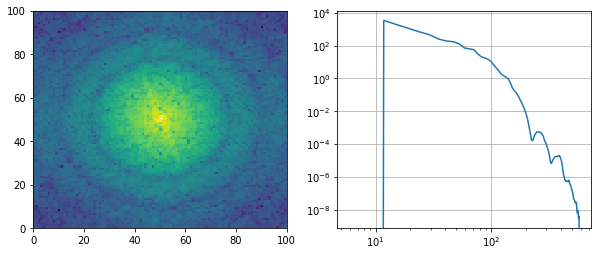

In [23]:
# try taking spectrum without interpolation

nnxx = int(Lchk/dx.mean())//4
ncvar = Dataset(file_topo,'r').variables
hh = ncvar['h'][jy-nnxx:jy+nnxx,ix-nnxx:ix+nnxx].T
xx = ncvar['lon_rho'][jy-nnxx:jy+nnxx,ix-nnxx:ix+nnxx].T
yy = ncvar['lat_rho'][jy-nnxx:jy+nnxx,ix-nnxx:ix+nnxx].T
Nx = hh.shape[0]
htr = hh.copy()
ddx = (np.diff(xx,axis=0).mean() + np.diff(yy,axis=1).mean())/2.
kx = np.fft.fftshift(np.fft.fftfreq(Nx,ddx))*2*np.pi # wavenumbers in x-direction = major axis
dk = kx[1]-kx[0]

win_x   = np.tile(np.hanning(Nx),(1,1))  # window before filtering 
win_y   = np.tile(np.hanning(Nx),(1,1)).T
win     = np.dot(win_y,win_x)
int_rec = Nx**2             # integral of a squared rectangular window (as if no windowing) 
int_win = np.nansum(win**2) # integral of the squared window 
norm    = (int_rec/int_win)*1/(Nx**2*dk**2) # [1/(rad m-1)^2] normalization constant 
hr_win = (hh - np.nanmean(hh))*win # remove mean and window the signal 
sp = norm*abs(np.fft.fftshift(np.fft.fft2(hr_win)))**2
sp = sp*np.nanvar(hi)/np.sum(sp*dk*dk)
kx2d,ky2d = np.meshgrid(kx,kx)
sp[np.where((kx2d**2+ky2d**2)==0.)]=np.nan # remove continuous component

sp_polar, r, theta = reproject_image_into_polar(sp.T,origin=(Nx//2,Nx//2))
kh = r*dk # r is in pixel, multiply by dk to get wavenumber
dtheta = theta[1]-theta[0]
sp_a = np.nansum(sp_polar*dtheta,axis=1)*kh/(2*np.pi)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
ax1.pcolormesh(np.ma.masked_invalid(np.log10(sp)))
ax2.loglog(kh,sp_a)
ax2.grid(True)

In [15]:
Nx

400